In [1]:
import os
import json
from collections import Counter, defaultdict

#  Path to the annotation file
annotations_path = "/kaggle/input/resnet101/dataset/train/_annotations.coco.json"

#  Load COCO annotations
with open(annotations_path, "r") as f:
    coco = json.load(f)

#  Mapping from class ID → name
id_to_class = {cat["id"]: cat["name"] for cat in coco["categories"]}

#  Count annotations and track images per class
ann_per_class = Counter()
images_per_class = defaultdict(set)

for ann in coco["annotations"]:
    class_id = ann["category_id"]
    image_id = ann["image_id"]
    ann_per_class[class_id] += 1
    images_per_class[class_id].add(image_id)

# Print dataset summary
print("Dataset Stats (from:", os.path.basename(annotations_path), ")")
print(f"Total Images: {len(coco['images'])}")
print(f"Total Annotations: {len(coco['annotations'])}\n")

# Print table with class ID
print(f"{'ID':<4} {'Class':<20} {'Annotations':>12} {'Images':>10}")
print("-" * 50)
for class_id in sorted(ann_per_class):
    name = id_to_class.get(class_id, f"Class {class_id}")
    print(f"{class_id:<4} {name:<20} {ann_per_class[class_id]:>12} {len(images_per_class[class_id]):>10}")


📊 Dataset Stats (from: _annotations.coco.json )
🔢 Total Images: 5493
🔢 Total Annotations: 7751

ID   Class                 Annotations     Images
--------------------------------------------------
1    Blood                        1139        794
2    Finger-print                  971        971
4    Hammer                       1056        854
5    Handgun                       979        790
6    Human-body                   1366        343
9    Knife                        1163        852
12   Shotgun                      1077        889


In [2]:
# Mapping of old IDs to new continuous IDs
id_mapping = {
    1: 1,
    2: 2,
    4: 3,
    5: 4,
    6: 5,
    9: 6,
    12: 7
}

def remap_category_ids(annotation_file, output_file):
    import json

    with open(annotation_file) as f:
        coco = json.load(f)

    # Remap categories
    new_categories = []
    for cat in coco["categories"]:
        if cat["id"] in id_mapping:
            new_categories.append({
                "id": id_mapping[cat["id"]],
                "name": cat["name"]
            })

    # Remap annotations
    new_annotations = []
    for ann in coco["annotations"]:
        if ann["category_id"] in id_mapping:
            ann["category_id"] = id_mapping[ann["category_id"]]
            new_annotations.append(ann)

    coco["categories"] = new_categories
    coco["annotations"] = new_annotations

    with open(output_file, "w") as f:
        json.dump(coco, f)
    print(f"Saved remapped annotation to {output_file}")


In [3]:
remap_category_ids("/kaggle/input/resnet101/dataset/train/_annotations.coco.json", "/kaggle/working/train_annotations.coco.json")
remap_category_ids("/kaggle/input/resnet101/dataset/valid/_annotations.coco.json", "/kaggle/working/valid_annotations.coco.json")
remap_category_ids("/kaggle/input/resnet101/dataset/test/_annotations.coco.json",  "/kaggle/working/test_annotations.coco.json")


✅ Saved remapped annotation to /kaggle/working/train_annotations.coco.json
✅ Saved remapped annotation to /kaggle/working/valid_annotations.coco.json
✅ Saved remapped annotation to /kaggle/working/test_annotations.coco.json


In [4]:
import json

def verify_category_ids(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    
    category_ids = [cat["id"] for cat in data["categories"]]
    print(f" {json_path}")
    print(" Category IDs:", category_ids)
    print(" Category Names:", [cat["name"] for cat in data["categories"]])
    print("-" * 50)

# Run verification on all three files
verify_category_ids("/kaggle/working/train_annotations.coco.json")
verify_category_ids("/kaggle/working/valid_annotations.coco.json")
verify_category_ids("/kaggle/working/test_annotations.coco.json")


📂 /kaggle/working/train_annotations.coco.json
✅ Category IDs: [1, 2, 3, 4, 5, 6, 7]
✅ Category Names: ['Blood', 'Finger-print', 'Hammer', 'Handgun', 'Human-body', 'Knife', 'Shotgun']
--------------------------------------------------
📂 /kaggle/working/valid_annotations.coco.json
✅ Category IDs: [1, 2, 3, 4, 5, 6, 7]
✅ Category Names: ['Blood', 'Finger-print', 'Hammer', 'Handgun', 'Human-body', 'Knife', 'Shotgun']
--------------------------------------------------
📂 /kaggle/working/test_annotations.coco.json
✅ Category IDs: [1, 2, 3, 4, 5, 6, 7]
✅ Category Names: ['Blood', 'Finger-print', 'Hammer', 'Handgun', 'Human-body', 'Knife', 'Shotgun']
--------------------------------------------------


In [5]:
!pip install pycocotools ensemble-boxes -q

In [6]:
import os
import json
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import ResNet101_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2


In [7]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image

class CrimeSceneDataset(Dataset):
    def __init__(self, root, transforms=None, annotation_file=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted([f for f in os.listdir(root) if f.endswith(('.jpg', '.png'))])

        # Load the cleaned annotation file from /kaggle/working
        if "train" in root:
            annotation_file = "/kaggle/working/train_annotations.coco.json"
        elif "valid" in root:
            annotation_file = "/kaggle/working/valid_annotations.coco.json"
        elif "test" in root:
            annotation_file = "/kaggle/working/test_annotations.coco.json"
        else:
            raise ValueError("Path must include 'train', 'valid', or 'test' to select the right annotation file.")

        with open(annotation_file, "r") as f:
            self.coco = json.load(f)

        # Remap category IDs to be continuous and start from 1
        self.category_mapping = {category["id"]: i + 1 for i, category in enumerate(self.coco["categories"])}
        self.image_id_map = {img["id"]: img["file_name"] for img in self.coco["images"]}

        # Filter annotations based on remapped category IDs
        self.annotations = {img_id: [] for img_id in self.image_id_map}
        for ann in self.coco["annotations"]:
            if ann["category_id"] in self.category_mapping:
                ann["category_id"] = self.category_mapping[ann["category_id"]]
                self.annotations[ann["image_id"]].append(ann)

        # Keep only images with valid annotations
        self.imgs = [img for img in self.imgs if self.has_valid_annotations(img)]
        self.annotations = {k: v for k, v in self.annotations.items() if v}

    def has_valid_annotations(self, img_filename):
        image_id = next((id for id, name in self.image_id_map.items() if name == img_filename), None)
        return image_id is not None and image_id in self.annotations and len(self.annotations[image_id]) > 0

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")
        image_id = next((id for id, name in self.image_id_map.items() if name == self.imgs[idx]), None)
        annotations = self.annotations.get(image_id, [])

        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [8]:
def get_transform(train=True):
    transforms = [T.ToTensor()]
    if train:
        transforms += [
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            T.RandomAutocontrast(p=0.15),
            T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
            T.RandomAffine(degrees=0, translate=(0.1,0.1)),
        ]
    return T.Compose(transforms)


In [9]:
from torch.utils.data import DataLoader

# Collate function for detection tasks
def collate_fn(batch):
    return tuple(zip(*batch))

# Paths
image_root = "/kaggle/input/resnet101/dataset"
ann_root = "/kaggle/working"  

# Initialize datasets using cleaned annotations
train_dataset = CrimeSceneDataset(
    root=os.path.join(image_root, "train"),
    transforms=get_transform(train=True),
    annotation_file=os.path.join(ann_root, "train_annotations.coco.json")  

valid_dataset = CrimeSceneDataset(
    root=os.path.join(image_root, "valid"),
    transforms=get_transform(train=False),
    annotation_file=os.path.join(ann_root, "valid_annotations.coco.json")  
)

test_dataset = CrimeSceneDataset(
    root=os.path.join(image_root, "test"),
    transforms=get_transform(train=False),
    annotation_file=os.path.join(ann_root, "test_annotations.coco.json")  
)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  7 foreground classes + 1 background class
num_classes = 8

backbone = resnet_fpn_backbone('resnet101', weights=ResNet101_Weights.DEFAULT)

anchor_generator = AnchorGenerator(
    sizes=((16,), (32,), (64,), (128,), (256,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator
)

model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 202MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [12]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(data_loader, desc=f" Epoch {epoch+1}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()

    return running_loss / len(data_loader)

def validate(model, data_loader, device):
    model.train()  #  Necessary to get loss_dict from model
    total_loss = 0.0

    for images, targets in tqdm(data_loader, desc=" Validating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():  # Prevents gradient computation
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    return total_loss / len(data_loader)



In [ ]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
import os

# Paths
best_checkpoint_path = "/kaggle/working/best_faster_rcnn_final4.pth"
latest_checkpoint_path = "/kaggle/working/latest_faster_rcnn_final4.pth"

# Training parameters
num_epochs = 35
patience = 5
epochs_no_improve = 0
start_epoch = 0
best_valid_loss = float("inf")

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

# Load checkpoint if exists
if os.path.exists(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"]
    best_valid_loss = checkpoint["best_valid_loss"]
    print(f" Resuming from epoch {start_epoch} (Best Val Loss: {best_valid_loss:.4f})")
else:
    print(" Starting from scratch")

# Training loop with resume
for epoch in range(start_epoch, num_epochs):
    # Optional: print current LR
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.6f}")

    # Training
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    
    # Validation
    valid_loss = validate(model, valid_loader, device)
    
    # Logging
    print(f"\n Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
    
    # Step scheduler
    scheduler.step(valid_loss)

    # Save BEST checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "best_valid_loss": best_valid_loss,
        }, best_checkpoint_path)
        print(" Best model checkpoint saved!")
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve} epoch(s)")

    # Always save LATEST checkpoint
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "best_valid_loss": best_valid_loss,
    }, latest_checkpoint_path)

    # Early stopping
    if epochs_no_improve >= patience:
        print(" Early stopping triggered.")
        break

    # Optional: clear GPU cache
    torch.cuda.empty_cache()

print("Training complete.")


In [13]:
import os
import shutil

# Create outputs directory if it doesn't exist
os.makedirs("/kaggle/working/outputs", exist_ok=True)

# Copy the checkpoint
shutil.copy("/kaggle/working/best_faster_rcnn_final4.pth", "/kaggle/working/outputs/best_faster_rcnn_final4.pth")


'/kaggle/working/outputs/best_faster_rcnn_final4.pth'

In [14]:
import torch

checkpoint_path = "/kaggle/working/best_faster_rcnn_final4.pth" 
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f" Loaded model trained up to epoch {checkpoint['epoch']} with best valid loss {checkpoint['best_valid_loss']:.4f}")


✅ Loaded model trained up to epoch 34 with best valid loss 0.1265


In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torch

class_names = {
    1: 'Blood',
    2: 'Finger-print',
    3: 'Hammer',
    4: 'Handgun',
    5: 'Human-body',
    6: 'Knife',
    7: 'Shotgun'
}

def detect_and_visualize_side_by_side(model, image_path, device, class_names, threshold=0.5):
    from PIL import Image
    import torchvision.transforms as T

    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = T.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    image_np = np.array(image)
    output_image = image_np.copy()

    boxes = prediction["boxes"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()


    for i in range(len(boxes)):
        if scores[i] >= threshold:
            x1, y1, x2, y2 = boxes[i].astype(int)
            label = class_names.get(labels[i], f"Class {labels[i]}")
            score = scores[i]
            cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(output_image, f"{label}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)


    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(image_np)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(output_image)
    axs[1].set_title("Predicted Bounding Boxes")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()




🔍 Predicting: 4485d4f8f43bd046_jpg.rf.d6f326a495b8766f36630643925d119a.jpg


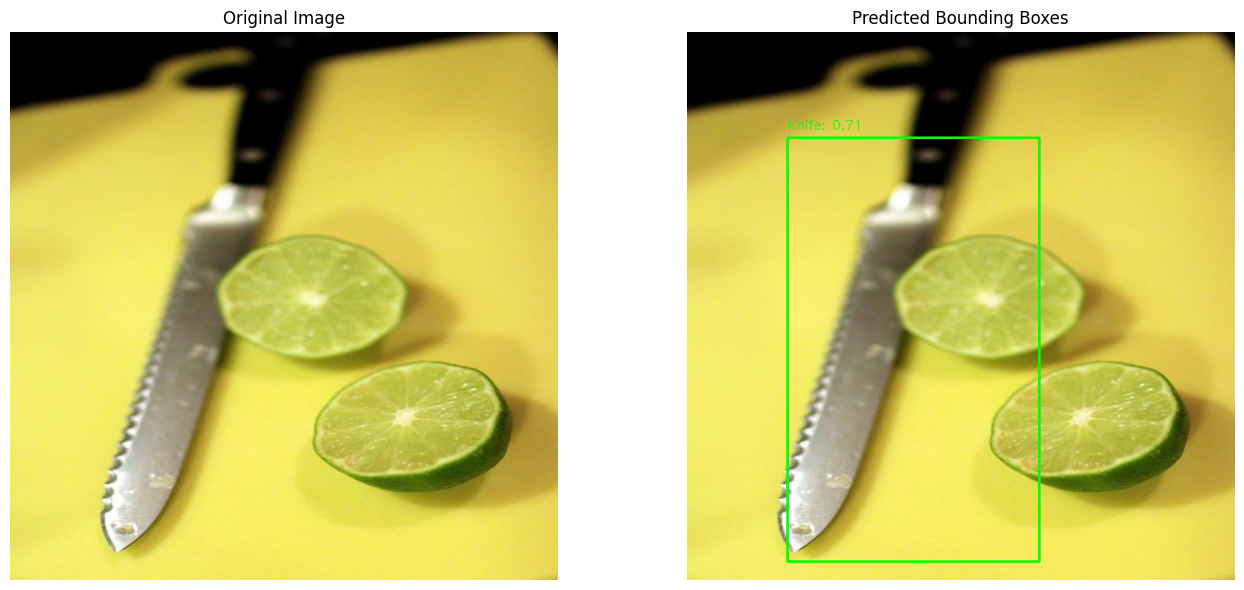


🔍 Predicting: 86__M_Left_thumb_finger_BMP.rf.461aef830729ad38378c51d10d8e3473.jpg


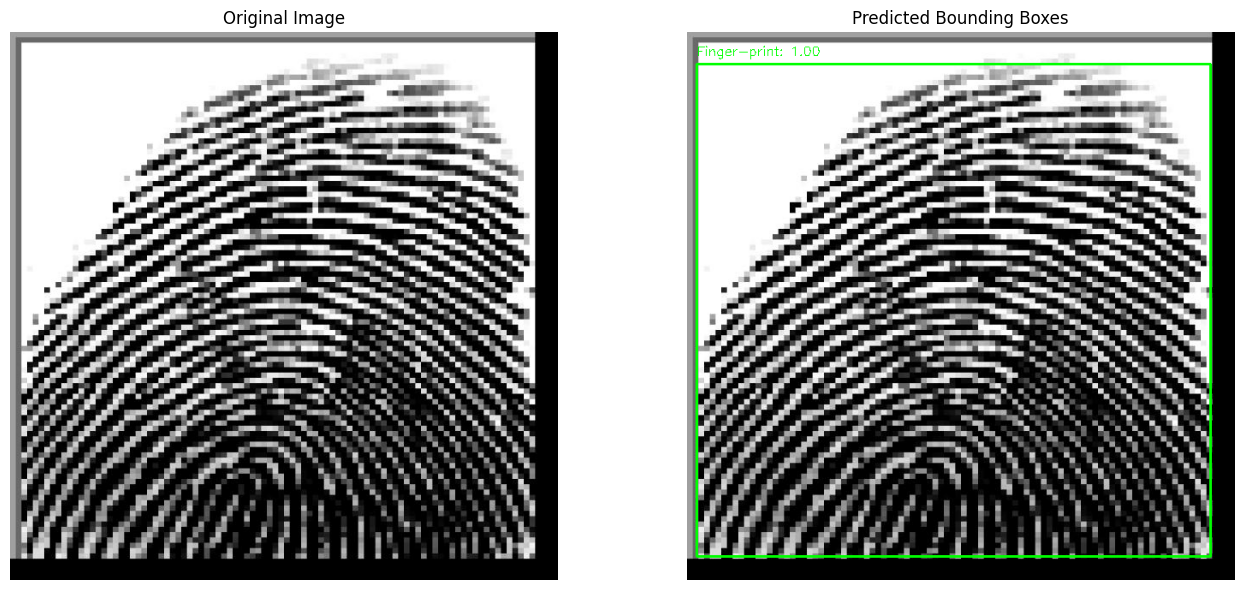


🔍 Predicting: 591__M_Left_index_finger_BMP.rf.436d8ddbb9c851a1492fe8d884944750.jpg


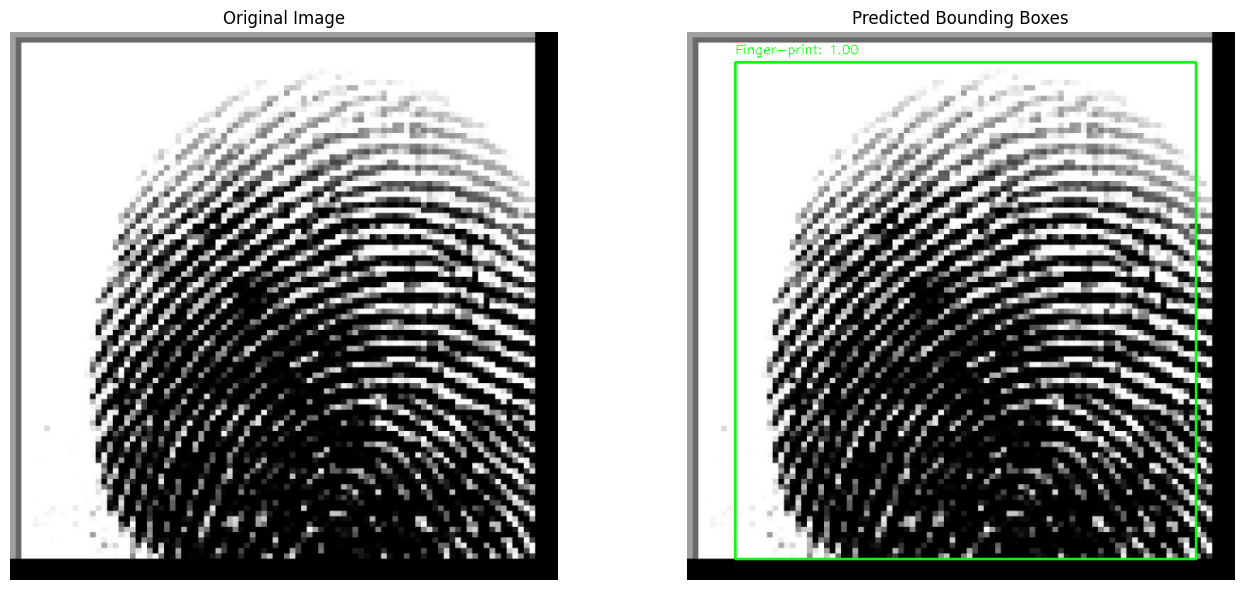


🔍 Predicting: 580__M_Left_ring_finger_BMP.rf.ab6bab0940b70a7d0929db3e7f77335e.jpg


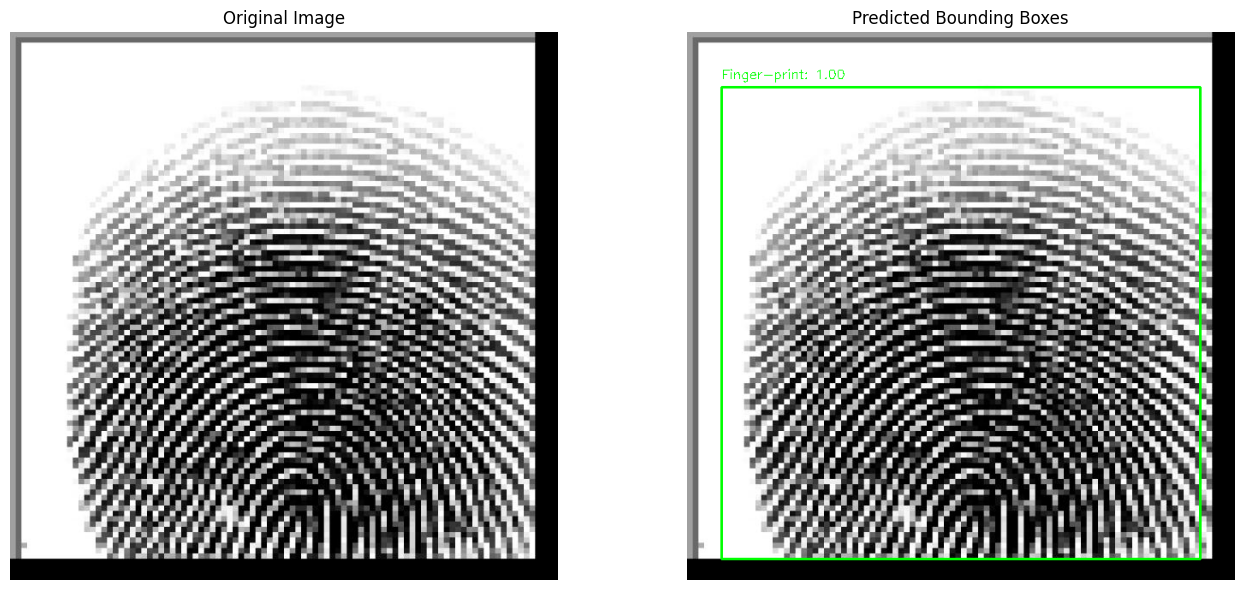


🔍 Predicting: 1b4bf12441f7e67c_jpg.rf.d22645aa58fa15de7b1cb91641c82549.jpg



🔍 Predicting: 20_w_bloodstains_53_jpg.rf.2bd2b6a1a22b5c7c4e236732019dd765.jpg


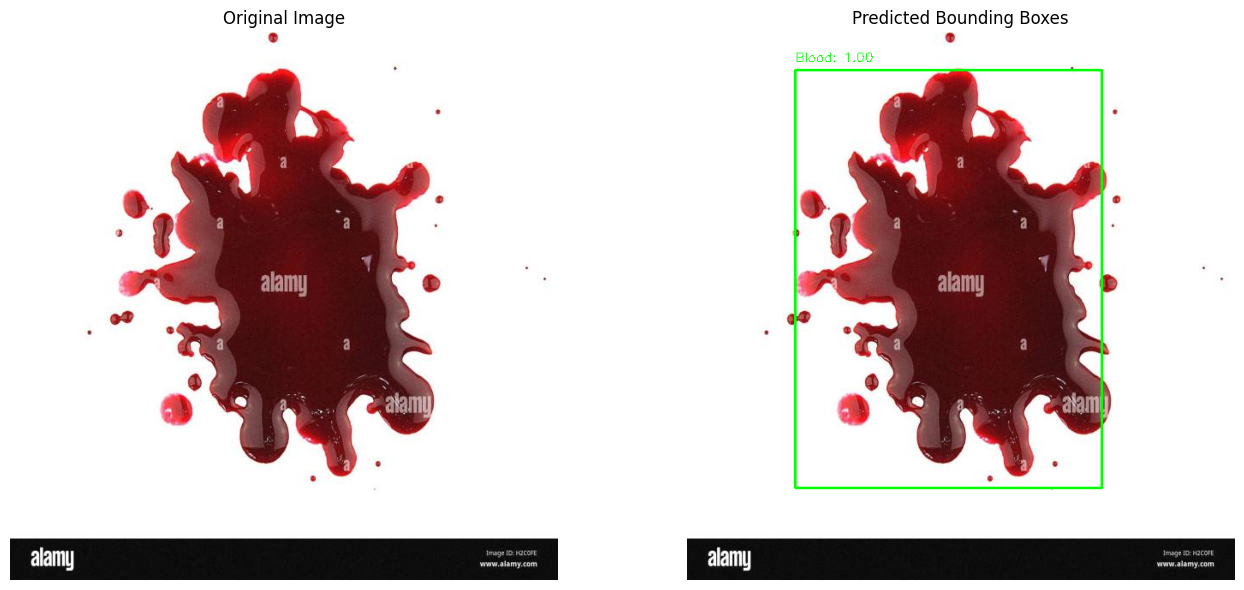


🔍 Predicting: 515485de81de3aea_jpg.rf.6c614f3d094667c1f13d3b59901fc395.jpg


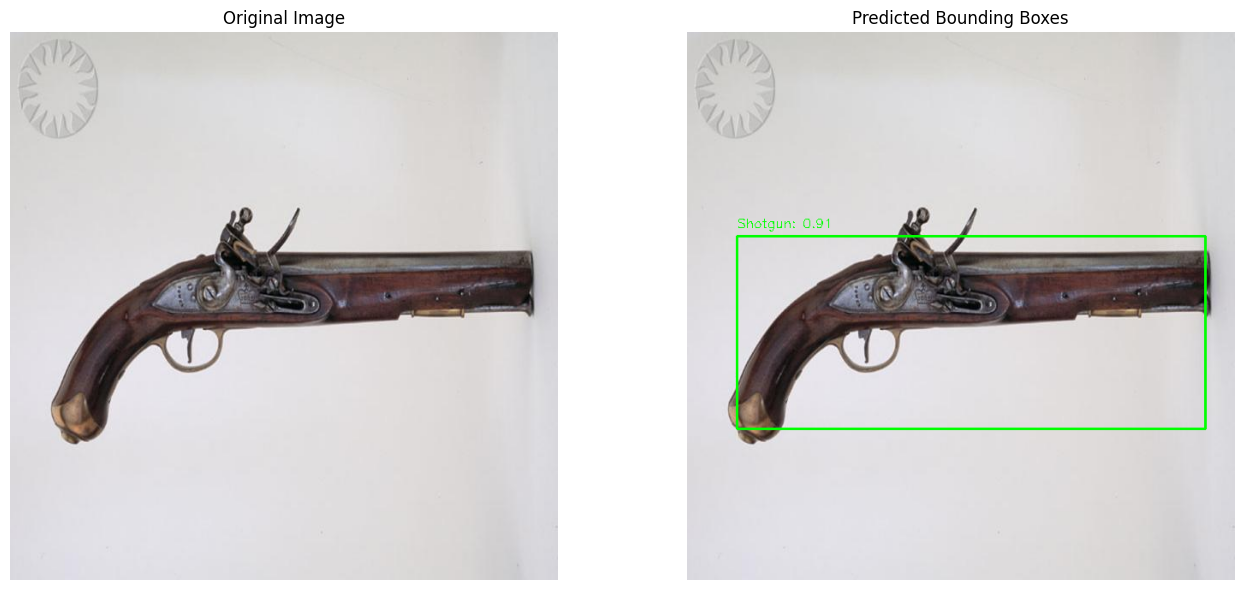


🔍 Predicting: 558__M_Right_middle_finger_BMP.rf.d15a29bb50f642bb00b8624c1d42b1ac.jpg



🔍 Predicting: 000131_jpg.rf.6adb8acb02d17c64a3ebc301de8a33cd.jpg


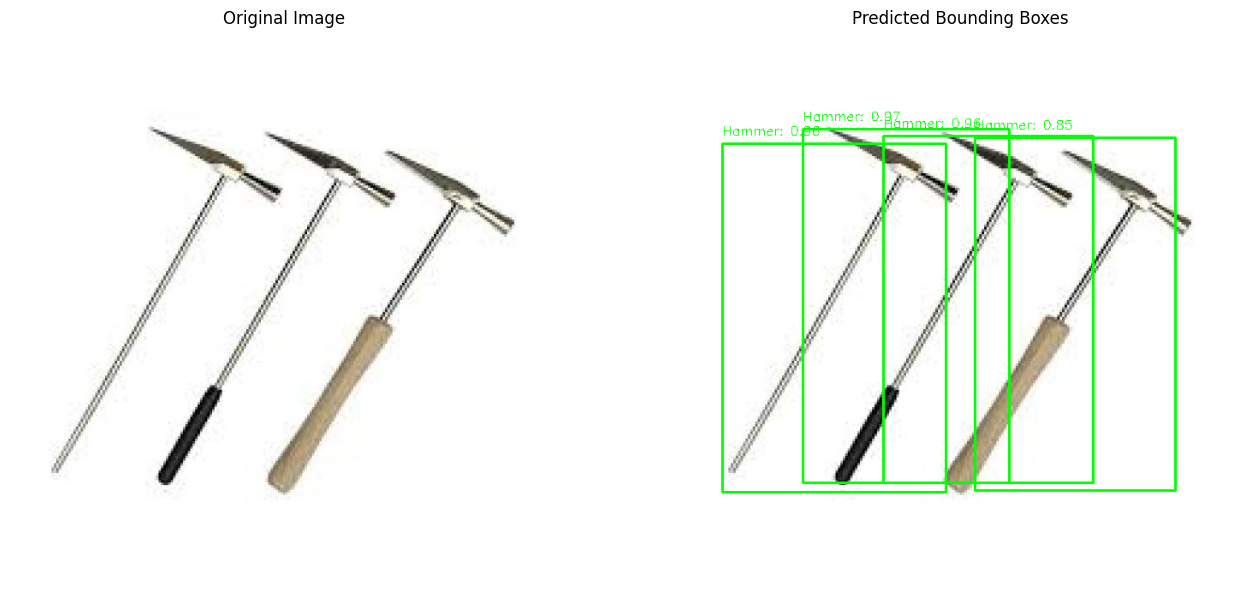


🔍 Predicting: 24c73572fe4e6dac_jpg.rf.50e95424093f32f04b21beafcb38f6af.jpg


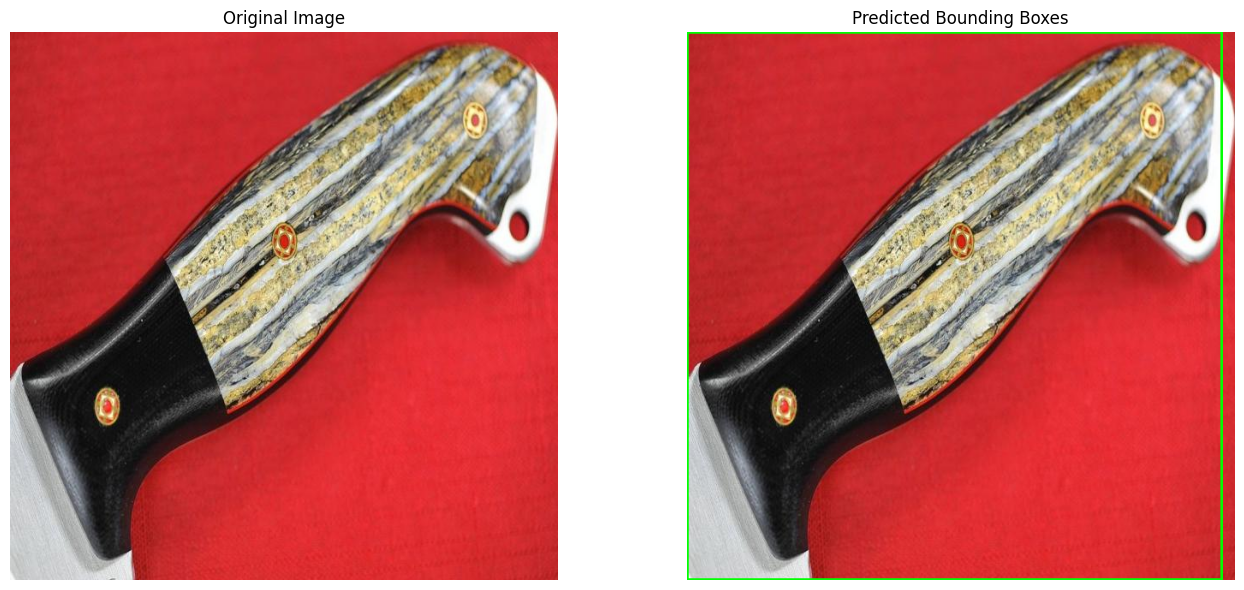


🔍 Predicting: 1e28cf9e0bcf227b_jpg.rf.f946513e89d1cd5f808b2cfa871e25f0.jpg


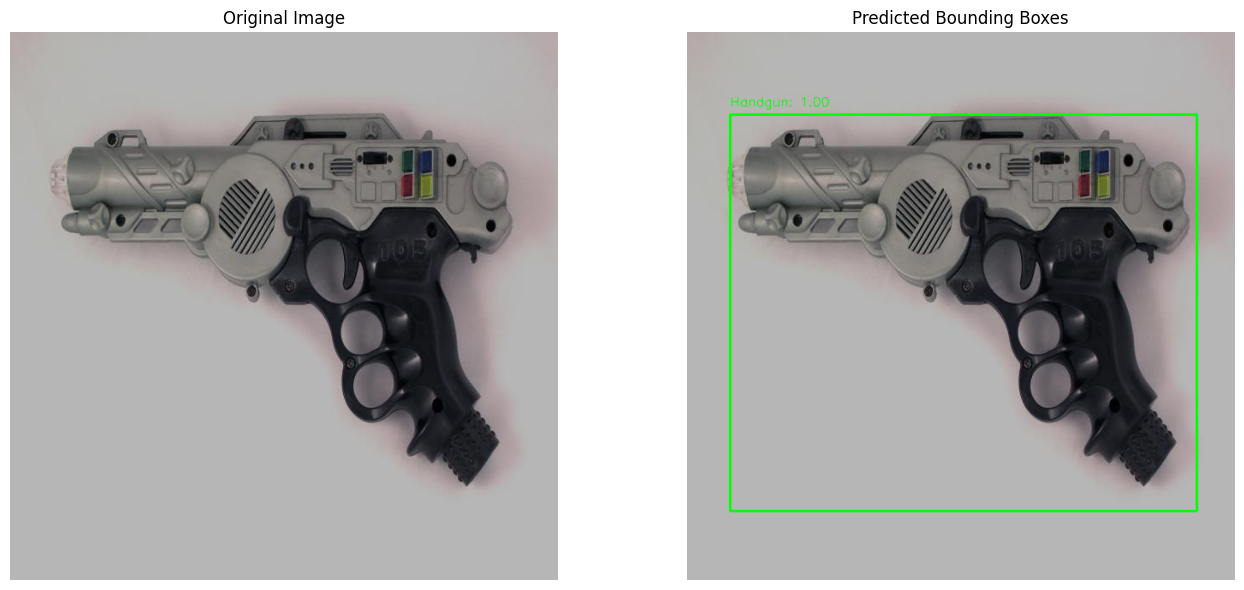


🔍 Predicting: 1fd4aa24eae1fa53_jpg.rf.ee85bf569c598e58c40c612555752ae2.jpg


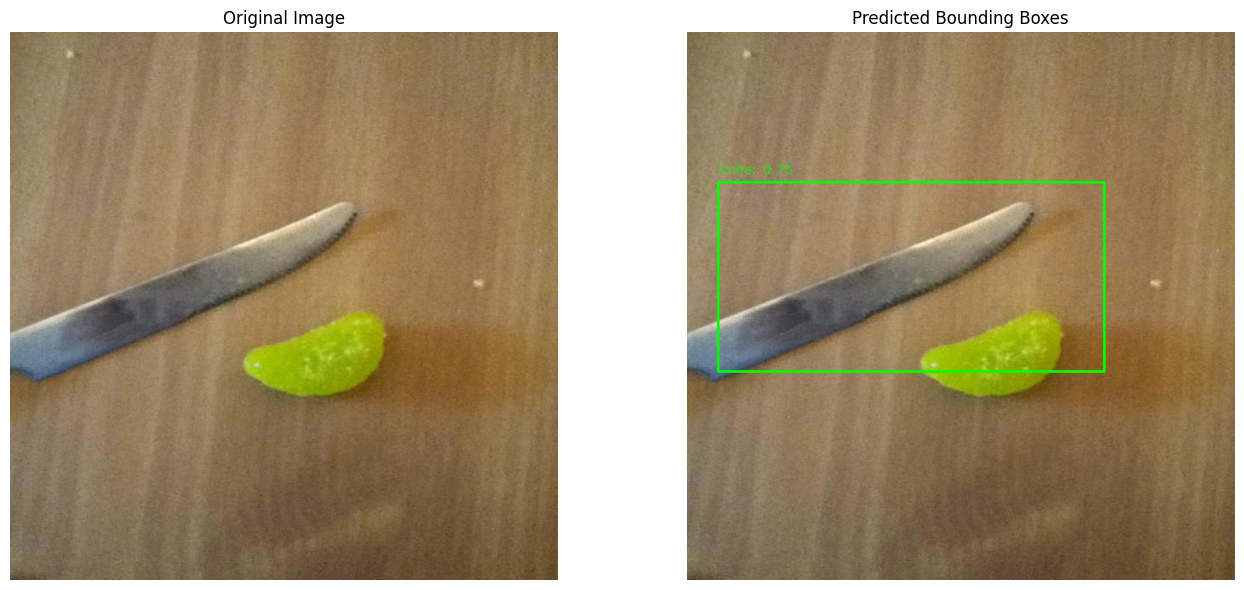


🔍 Predicting: 624104f76b1d2496_jpg.rf.9be03fd7780cfbea18acabd98e8a2689.jpg


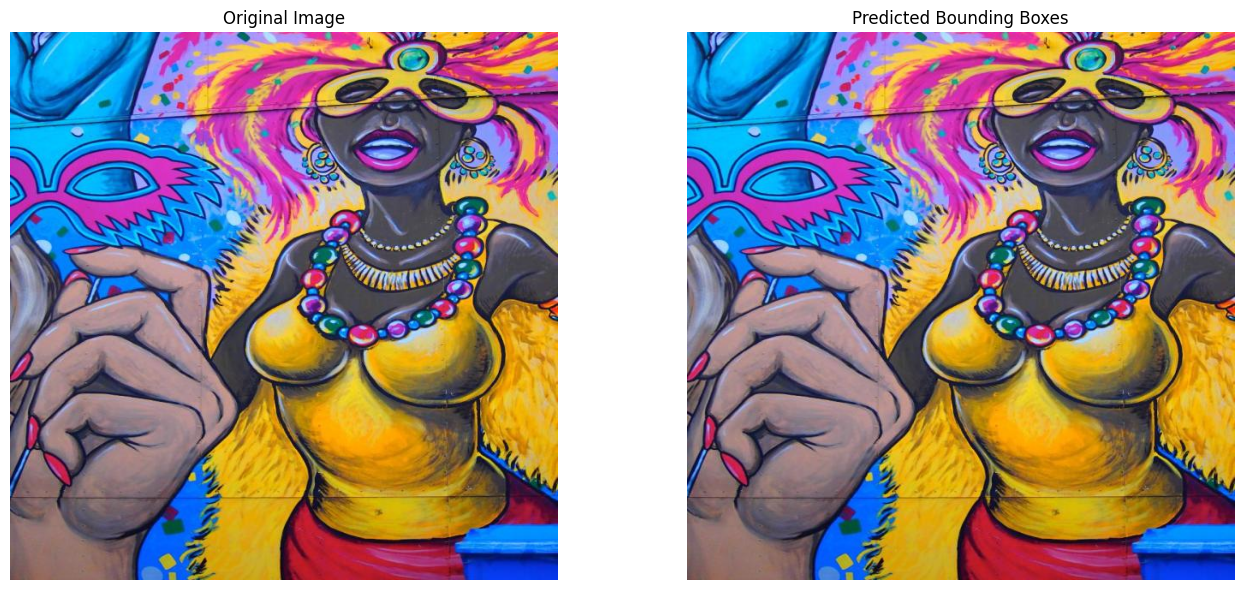


🔍 Predicting: 31b12c2ba850b805_jpg.rf.aa8bd3d695a014a9572550f2bcb9259a.jpg


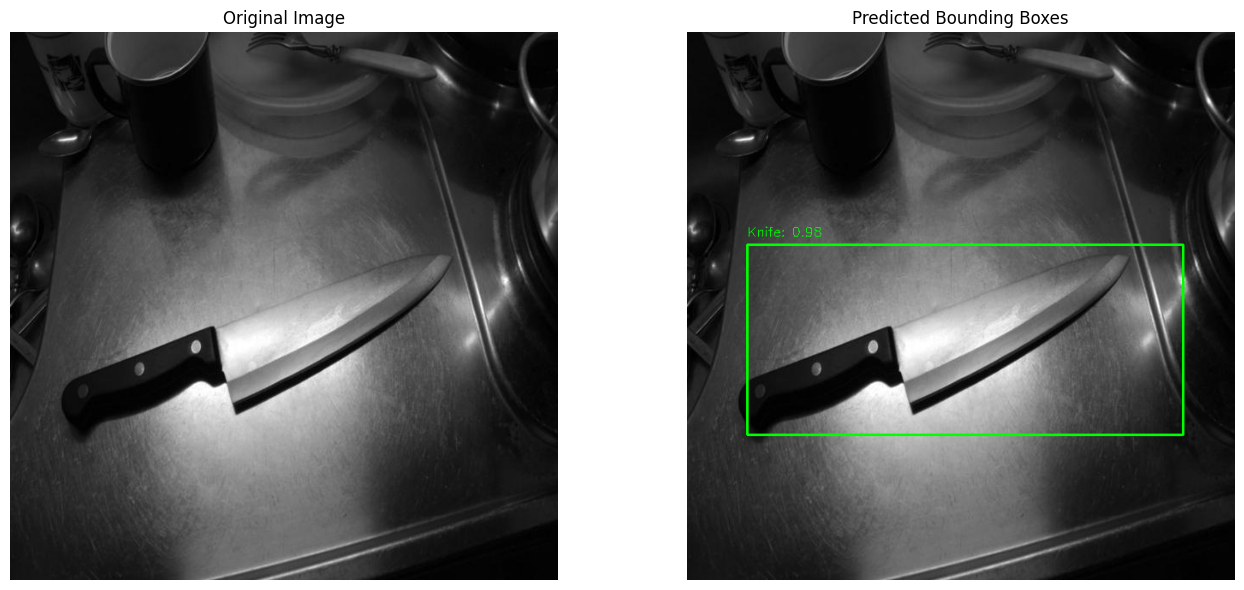


🔍 Predicting: 2026123fa11b1885_jpg.rf.177de1268f170b46f6e00512cd040331.jpg


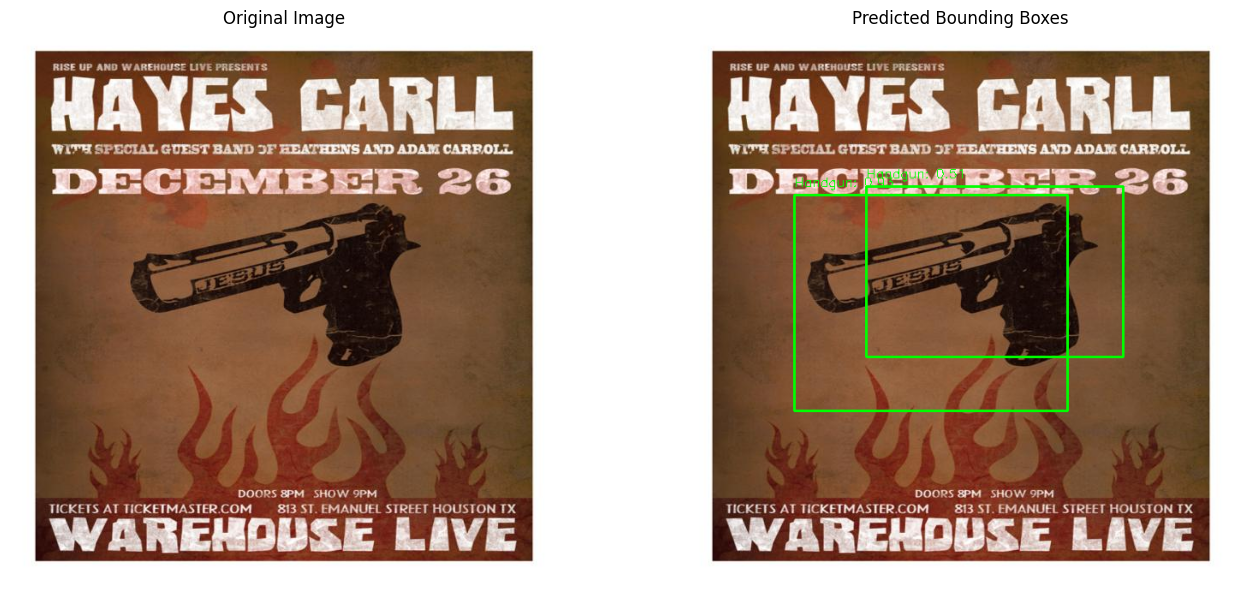

In [18]:
import os
import random

# Path to test folder
test_folder = "/kaggle/input/resnet101/dataset/test"

# Choose test images
test_images = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

# Set number of random images to test
num_images = 15

# Randomly select images
random_images = random.sample(test_images, min(num_images, len(test_images)))

# Run detection
for img_name in random_images:
    print(f"\n Predicting: {img_name}")
    image_path = os.path.join(test_folder, img_name)
    detect_and_visualize_side_by_side(model, image_path, device, class_names)


In [15]:
import torch
import numpy as np
from torchvision.ops import box_iou, nms

def evaluate_metrics(model, data_loader, device, iou_threshold=0.6, conf_thresh=0.5):
    """
    Evaluate object detection model using precision, recall, and accuracy.
    Uses confidence thresholding and Non-Maximum Suppression (NMS).
    """
    model.eval()
    total_tp, total_fp, total_fn = 0, 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for pred, target in zip(outputs, targets):
                pred_boxes = pred["boxes"].cpu()
                pred_scores = pred["scores"].cpu()
                gt_boxes = target["boxes"].cpu()

                # Apply confidence threshold
                keep = pred_scores > conf_thresh
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                # Apply NMS
                if len(pred_boxes) > 0:
                    keep_nms = nms(pred_boxes, pred_scores, iou_threshold=0.5)
                    pred_boxes = pred_boxes[keep_nms]
                    pred_scores = pred_scores[keep_nms]

                # Handle edge cases
                if len(gt_boxes) == 0:
                    total_fp += len(pred_boxes)
                    continue
                if len(pred_boxes) == 0:
                    total_fn += len(gt_boxes)
                    continue

                # Match predictions to ground truth using IoU
                ious = box_iou(pred_boxes, gt_boxes)
                max_ious, _ = ious.max(dim=1)

                tp = (max_ious >= iou_threshold).sum().item()
                fp = len(pred_boxes) - tp
                fn = len(gt_boxes) - tp

                total_tp += tp
                total_fp += fp
                total_fn += fn

    # Final metrics
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    accuracy = total_tp / (total_tp + total_fp + total_fn + 1e-6)

    return precision, recall, accuracy

# Run it on your Kaggle-trained model and validation set
precision, recall, accuracy = evaluate_metrics(model, valid_loader, device,iou_threshold=0.4, conf_thresh=0.45)
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" Accuracy: {accuracy:.4f}")


📊 Precision: 0.7677
📊 Recall: 0.9272
📊 Accuracy: 0.7241


In [16]:
import torch
import numpy as np
from torchvision.ops import box_iou

def calculate_mAP(model, data_loader, device, iou_threshold=0.5):
    """
    Computes approximate mean Average Precision (mAP) for object detection.
    Note: This is not COCO-style mAP with multiple thresholds and per-class AP.
    """
    model.eval()
    all_precisions = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred["boxes"].cpu()
                pred_scores = pred["scores"].cpu()
                gt_boxes = target["boxes"].cpu()

                if len(gt_boxes) == 0:
                    all_precisions.append(0.0)
                    continue

                if len(pred_boxes) == 0:
                    all_precisions.append(0.0)
                    continue

                # Sort predictions by confidence
                sorted_indices = torch.argsort(pred_scores, descending=True)
                pred_boxes = pred_boxes[sorted_indices]

                # Compute IoUs
                ious = box_iou(pred_boxes, gt_boxes)
                max_ious, _ = ious.max(dim=1)

                # Count TP, FP, FN
                tp = (max_ious >= iou_threshold).sum().item()
                fp = len(pred_boxes) - tp
                fn = len(gt_boxes) - tp

                precision = tp / (tp + fp + 1e-6)
                recall = tp / (tp + fn + 1e-6)

                # Approximate Average Precision
                ap = precision * recall
                all_precisions.append(ap)

    # Mean of APs across all samples
    return np.mean(all_precisions) if all_precisions else 0.0

#  Run mAP evaluation
mAP_score = calculate_mAP(model, valid_loader, device, iou_threshold=0.45)
print(f" Model mAP (approx): {mAP_score:.4f}")


📊 Model mAP (approx): 0.9589


In [17]:
import torch
import numpy as np
from collections import defaultdict
from torchvision.ops import box_iou
from tqdm import tqdm

def per_class_metrics(model, data_loader, device, class_names, iou_threshold=0.4, conf_threshold=0.45):
    model.eval()
    stats = {cls_id: {"TP": 0, "FP": 0, "FN": 0} for cls_id in class_names.keys()}

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc=" Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                gt_boxes = targets[i]["boxes"].cpu()
                gt_labels = targets[i]["labels"].cpu()

                pred_boxes = outputs[i]["boxes"].cpu()
                pred_labels = outputs[i]["labels"].cpu()
                pred_scores = outputs[i]["scores"].cpu()

                # Filter low-confidence predictions
                keep = pred_scores >= conf_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                matched_gt = set()

                for j, pred_box in enumerate(pred_boxes):
                    pred_label = pred_labels[j].item()

                    ious = box_iou(pred_box.unsqueeze(0), gt_boxes)
                    max_iou, max_idx = ious.max(dim=1)

                    if max_iou >= iou_threshold and gt_labels[max_idx] == pred_label and max_idx.item() not in matched_gt:
                        stats[pred_label]["TP"] += 1
                        matched_gt.add(max_idx.item())
                    else:
                        stats[pred_label]["FP"] += 1

                # Count FN for each unmatched ground truth
                for k, gt_label in enumerate(gt_labels):
                    if k not in matched_gt:
                        stats[gt_label.item()]["FN"] += 1

    #  Print per-class metrics
    print(f"\n Per-Class Metrics (IoU Threshold={iou_threshold}, Confidence Threshold={conf_threshold})")
    print(f"{'ID':<3} {'Class Name':<18} {'Precision':>9} {'Recall':>9} {'F1-Score':>9} {'Support':>9}")
    print("-" * 65)
    for cls_id, cls_name in class_names.items():
        TP = stats[cls_id]["TP"]
        FP = stats[cls_id]["FP"]
        FN = stats[cls_id]["FN"]

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        support = TP + FN

        print(f"{cls_id:<3} {cls_name:<18} {precision:9.3f} {recall:9.3f} {f1:9.3f} {support:9}")


In [18]:
class_names = {
    1: 'Blood',
    2: 'Finger-print',
    3: 'Hammer',
    4: 'Handgun',
    5: 'Human-body',
    6: 'Knife',
    7: 'Shotgun'
}

per_class_metrics(model, valid_loader, device, class_names)


🔍 Evaluating: 100%|██████████| 387/387 [01:42<00:00,  3.76it/s]


📊 Per-Class Metrics (IoU Threshold=0.4, Confidence Threshold=0.45)
ID  Class Name         Precision    Recall  F1-Score   Support
-----------------------------------------------------------------
1   Blood                  0.527     0.387     0.447       351
2   Finger-print           0.764     0.997     0.865       311
3   Hammer                 0.513     0.851     0.640       350
4   Handgun                0.605     0.636     0.620       352
5   Human-body             0.344     0.412     0.375       437
6   Knife                  0.520     0.738     0.610       362
7   Shotgun                0.552     0.677     0.608       350


In [19]:
from collections import defaultdict
from torchvision.ops import box_iou
import torch
from tqdm import tqdm

def per_class_accuracy(model, data_loader, device, class_names, iou_threshold=0.4 ,conf_threshold=0.45):
    model.eval()
    class_stats = {cls_id: {"TP": 0, "FP": 0, "FN": 0} for cls_id in class_names.keys()}

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc=" Computing Per-Class Accuracy"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for preds, target in zip(outputs, targets):
                pred_boxes = preds["boxes"].cpu()
                pred_labels = preds["labels"].cpu()
                pred_scores = preds["scores"].cpu()
                gt_boxes = target["boxes"].cpu()
                gt_labels = target["labels"].cpu()

                # Filter by confidence
                keep = pred_scores >= conf_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                matched_pred = set()
                matched_gt = set()

                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)
                    for i in range(ious.shape[0]):
                        for j in range(ious.shape[1]):
                            if ious[i, j] >= iou_threshold and i not in matched_pred and j not in matched_gt:
                                pred_cls = pred_labels[i].item()
                                gt_cls = gt_labels[j].item()
                                if pred_cls == gt_cls:
                                    class_stats[pred_cls]["TP"] += 1
                                else:
                                    class_stats[pred_cls]["FP"] += 1
                                    class_stats[gt_cls]["FN"] += 1
                                matched_pred.add(i)
                                matched_gt.add(j)

                # Count unmatched predictions
                for i in range(len(pred_boxes)):
                    if i not in matched_pred:
                        cls_id = pred_labels[i].item()
                        class_stats[cls_id]["FP"] += 1

                for j in range(len(gt_boxes)):
                    if j not in matched_gt:
                        cls_id = gt_labels[j].item()
                        class_stats[cls_id]["FN"] += 1

    print("\n Per-Class Accuracy")
    print("ID  Class Name        TP    FP    FN    Accuracy")
    print("-" * 50)
    for cls_id, stats in class_stats.items():
        TP, FP, FN = stats["TP"], stats["FP"], stats["FN"]
        acc = TP / (TP + FP + FN + 1e-6)
        print(f"{cls_id:<3} {class_names[cls_id]:<16} {TP:<5} {FP:<5} {FN:<5} {acc:.4f}")


In [20]:
class_names = {
    1: 'Blood',
    2: 'Finger-print',
    3: 'Hammer',
    4: 'Handgun',
    5: 'Human-body',
    6: 'Knife',
    7: 'Shotgun'
}

per_class_accuracy(model, valid_loader, device, class_names)


🔍 Computing Per-Class Accuracy: 100%|██████████| 387/387 [01:42<00:00,  3.77it/s]


📊 Per-Class Accuracy
ID  Class Name        TP    FP    FN    Accuracy
--------------------------------------------------
1   Blood            136   122   215   0.2875
2   Finger-print     310   96    1     0.7617
3   Hammer           298   283   52    0.4708
4   Handgun          220   150   132   0.4382
5   Human-body       182   342   255   0.2336
6   Knife            265   248   97    0.4344
7   Shotgun          233   196   117   0.4267


In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision.ops import box_iou
import seaborn as sns
import matplotlib.pyplot as plt

#  Class Names
CLASS_NAMES = [
    "background", "Blood", "Finger-print", "Hammer", "Handgun",
    "Human-body","Knife", "Shotgun"
]
NUM_CLASSES = len(CLASS_NAMES)

def compute_confusion_matrix_cleaned(model, data_loader, device, iou_threshold=0.4, conf_threshold=0.45):
    model.eval()
    gt_labels_all = []
    pred_labels_all = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                gt_boxes = targets[i]['boxes'].cpu()
                gt_labels = targets[i]['labels'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu()
                pred_scores = outputs[i]['scores'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()

                # Filter low-confidence predictions
                keep = pred_scores >= conf_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue

                elif len(gt_boxes) == 0:
                    gt_labels_all.extend([0] * len(pred_labels))  # all are false positives
                    pred_labels_all.extend(pred_labels.tolist())
                    continue

                elif len(pred_boxes) == 0:
                    gt_labels_all.extend(gt_labels.tolist())  # all are false negatives
                    pred_labels_all.extend([0] * len(gt_labels))
                    continue

                # Compute IoUs
                ious = box_iou(pred_boxes, gt_boxes)
                matched_gt = set()
                for pred_idx in range(len(pred_boxes)):
                    max_iou, gt_idx = ious[pred_idx].max(0)
                    pred_class = pred_labels[pred_idx]
                    if max_iou >= iou_threshold and gt_idx.item() not in matched_gt:
                        gt_class = gt_labels[gt_idx.item()]
                        pred_labels_all.append(pred_class)
                        gt_labels_all.append(gt_class)
                        matched_gt.add(gt_idx.item())
                    else:
                        pred_labels_all.append(pred_class)
                        gt_labels_all.append(0)  # background

                # Unmatched GT boxes (FN)
                for j in range(len(gt_boxes)):
                    if j not in matched_gt:
                        gt_labels_all.append(gt_labels[j])
                        pred_labels_all.append(0)

    # Generate confusion matrix
    cm = confusion_matrix(gt_labels_all, pred_labels_all, labels=list(range(NUM_CLASSES)))

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Cleaned Classes")
    plt.show()

    return cm
cm_cleaned = compute_confusion_matrix_cleaned(model, valid_loader, device)


In [23]:
import pandas as pd
import numpy as np

def compute_metrics_from_cm(cm, class_names):
    """
    Computes precision, recall, and F1-score for each class from a confusion matrix.
    """
    num_classes = len(class_names)
    metrics = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        metrics.append({
            "Class ID": i,
            "Class Name": class_names[i],
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1-score": round(f1, 3),
            "Support": int(cm[i, :].sum())
        })

    return pd.DataFrame(metrics)

CLASS_NAMES = [
    "background", "Blood", "Finger-print", "Hammer", "Handgun",
    "Human-body","Knife", "Shotgun"
]


metrics_df = compute_metrics_from_cm(cm_cleaned, CLASS_NAMES)
print(metrics_df.to_string(index=False))


 Class ID   Class Name  Precision  Recall  F1-score  Support
        0   background      0.000   0.000     0.000     1309
        1        Blood      0.527   0.387     0.447      351
        2 Finger-print      0.764   0.997     0.865      311
        3       Hammer      0.511   0.849     0.638      350
        4      Handgun      0.595   0.625     0.609      352
        5   Human-body      0.344   0.412     0.375      437
        6        Knife      0.519   0.735     0.608      362
        7      Shotgun      0.538   0.660     0.593      350


In [15]:
!pip install grad-cam==1.5.0 opencv-python matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.

In [17]:
import json
import os

# Path to your cleaned test annotations
test_json = "/kaggle/working/test_annotations.coco.json"
image_root = "/kaggle/input/resnet101/dataset/test"

# Load COCO-style annotation file
with open(test_json, "r") as f:
    data = json.load(f)

# Map image IDs → filenames
image_id_to_name = {img["id"]: img["file_name"] for img in data["images"]}

# Find one sample image per class
sample_images = {}
for ann in data["annotations"]:
    cls_id = ann["category_id"]
    if cls_id not in sample_images:
        sample_images[cls_id] = image_id_to_name[ann["image_id"]]
    if len(sample_images) == len(data["categories"]):
        break

# Print the selected samples
print("One test image per class:")
for cls in data["categories"]:
    cid = cls["id"]
    cname = cls["name"]
    img_file = sample_images.get(cid, None)
    print(f"  {cid}: {cname} → {img_file}")

# Build absolute paths
image_paths = [os.path.join(image_root, f) for f in sample_images.values()]


✅ One test image per class:
  1: Blood → 20160608lnp1-bloodstains_jpg.rf.121f0393a0de884a755201afab16cc79.jpg
  2: Finger-print → istockphoto-172671581-170667a_jpg.rf.5acfb0d660fb2e845c32e415d9c4e417.jpg
  3: Hammer → 09b57aef25b2d0f5_jpg.rf.03954760572685676dea82916cd1dd02.jpg
  4: Handgun → 46db2f2bd6a859bd_jpg.rf.02b36024e533923c633a7a61aee30ed6.jpg
  5: Human-body → 8ff454d96fc7ac66_jpg.rf.0393f4d3dfb17dbe498edab36d595b9a.jpg
  6: Knife → b9a76baef5ccb666_jpg.rf.0127af73c06f8a0dde6d1f6874a69fac.jpg
  7: Shotgun → 9445b3428ddff0a8_jpg.rf.04136549c3b746ffb657f540c9f5a269.jpg



🔍 Visualizing 8ff454d96fc7ac66_jpg.rf.0393f4d3dfb17dbe498edab36d595b9a.jpg
🎯 Class: Human-body, Score: 0.91



🔍 Visualizing 09b57aef25b2d0f5_jpg.rf.03954760572685676dea82916cd1dd02.jpg
🎯 Class: Hammer, Score: 0.99



🔍 Visualizing b9a76baef5ccb666_jpg.rf.0127af73c06f8a0dde6d1f6874a69fac.jpg
🎯 Class: Knife, Score: 0.99


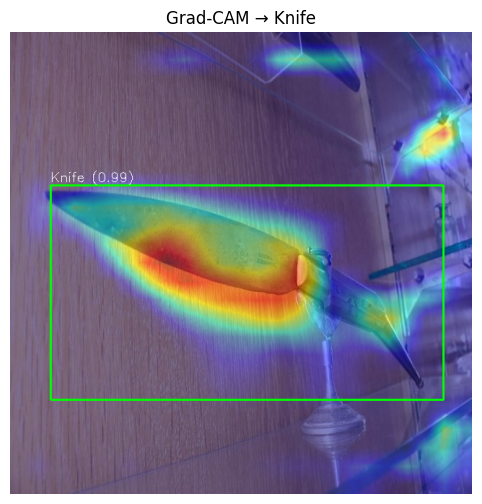


🔍 Visualizing 46db2f2bd6a859bd_jpg.rf.02b36024e533923c633a7a61aee30ed6.jpg
🎯 Class: Shotgun, Score: 0.36


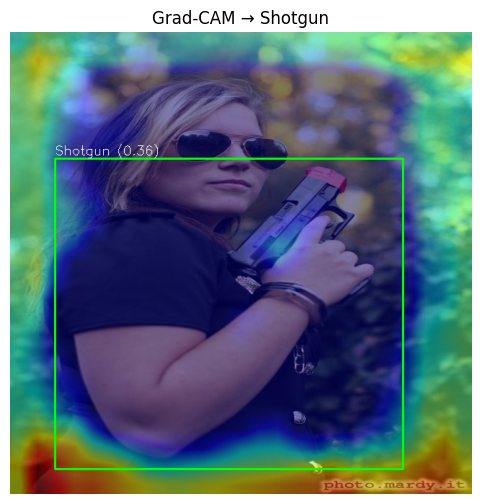


🔍 Visualizing 9445b3428ddff0a8_jpg.rf.04136549c3b746ffb657f540c9f5a269.jpg
🎯 Class: Human-body, Score: 0.64


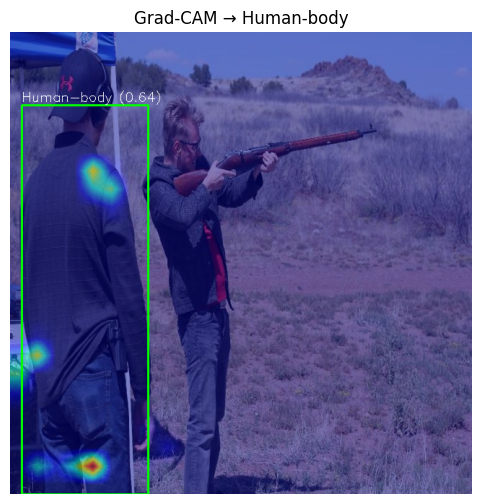


🔍 Visualizing 20160608lnp1-bloodstains_jpg.rf.121f0393a0de884a755201afab16cc79.jpg
🎯 Class: Blood, Score: 0.74


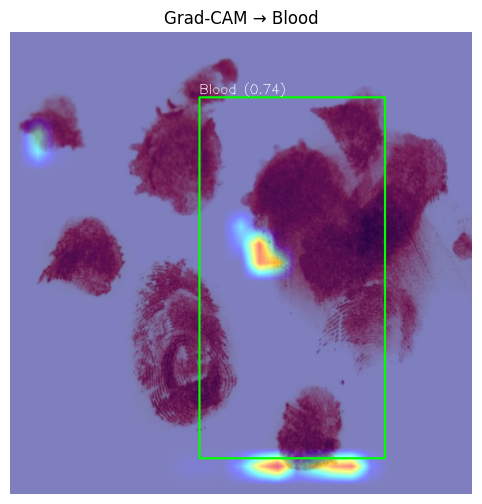


🔍 Visualizing istockphoto-172671581-170667a_jpg.rf.5acfb0d660fb2e845c32e415d9c4e417.jpg
🎯 Class: Finger-print, Score: 0.98


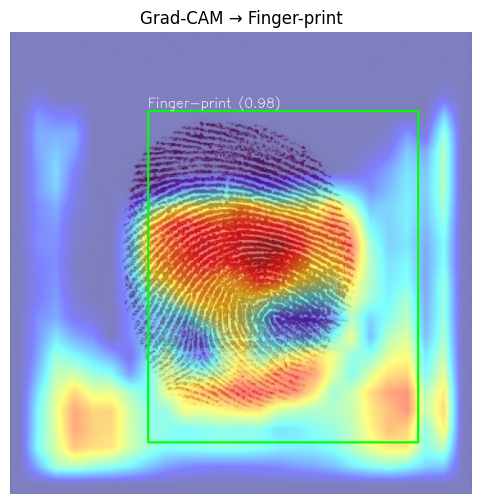

In [19]:
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Target layer: last convolutional block in backbone
target_layers = [model.backbone.body.layer4[-1]]

# Create Grad-CAM object
cam = GradCAM(model=model, target_layers=target_layers)

# Transform
transform = T.Compose([T.ToTensor()])

# Loop over sample images
for path in image_paths:
    print(f"\n Visualizing {os.path.basename(path)}")
    image = Image.open(path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)

    boxes = outputs[0]["boxes"].detach().cpu().numpy()
    labels = outputs[0]["labels"].detach().cpu().numpy()
    scores = outputs[0]["scores"].detach().cpu().numpy()

    if len(boxes) == 0:
        print(" No detections found for this image.")
        continue

    # Select the highest confidence detection
    idx = np.argmax(scores)
    target_box = boxes[idx]
    target_label = labels[idx]
    target_score = scores[idx]

    print(f" Class: {class_names[target_label]}, Score: {target_score:.2f}")

    # Define Grad-CAM target
    targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

    # Compute Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Overlay CAM on image
    rgb_img = np.array(image) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Draw detected box
    x1, y1, x2, y2 = target_box.astype(int)
    vis_box = visualization.copy()
    cv2.rectangle(vis_box, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(vis_box, f"{class_names[target_label]} ({target_score:.2f})", 
                (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    # Display final Grad-CAM result
    plt.figure(figsize=(10, 6))
    plt.imshow(vis_box)
    plt.title(f"Grad-CAM -> {class_names[target_label]}")
    plt.axis("off")
    plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


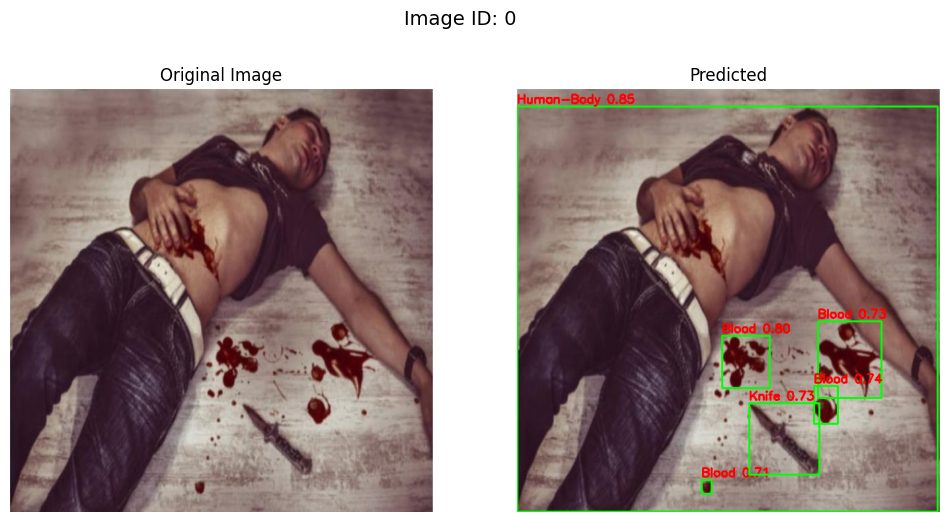

In [2]:
import cv2
import matplotlib.pyplot as plt
import random
import os
from pycocotools.coco import COCO

# Paths
data_dir = "/kaggle/input/humanbody/train"
ann_file = os.path.join(data_dir, "_annotations.coco.json")

# Load COCO annotations
coco = COCO(ann_file)
img_ids = coco.getImgIds()

# Pick one random image
img_id = random.choice(img_ids)
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(data_dir, img_info['file_name'])

# Load original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Copy for drawing boxes
annotated_img = original_img.copy()

# Load annotations for this image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Simulate model predictions (for example only)
# Replace this list with your actual model output
predictions = []
for ann in anns:
    x, y, w, h = ann['bbox']
    cat_id = ann['category_id']
    label = coco.loadCats(cat_id)[0]['name']
    score = round(random.uniform(0.7, 0.99), 2)  # Dummy confidence for visualization
    predictions.append({"bbox": [x, y, w, h], "category": label, "score": score})

# Draw predicted boxes with confidence
for pred in predictions:
    x, y, w, h = pred["bbox"]
    label = pred["category"]
    score = pred["score"]
    cv2.rectangle(annotated_img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    cv2.putText(
        annotated_img, f"{label} {score:.2f}", (int(x), int(y) - 5),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2
    )

# Show original vs annotated image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(annotated_img)
plt.title("Predicted")
plt.axis("off")

plt.suptitle(f"Image ID: {img_id}", fontsize=14)
plt.show()
